In [1]:
# \\dom1\Core\Dept\FPS\Programs\SDMA\Strategic_Mission_Assessments\02_Air_Force_A10\A10_Analysis\3_Sentiment_Analysis\Unit_Effectiveness_Inspection\UEI Sentiment Analysis
# Target File: consolidated_uei_dgw_121621.csv



### IMPORT MODULES

In [3]:

import pandas as pd
import numpy as np
import sklearn
import urllib
###################import SMA_Properties as sma_prop
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import os
import time
from sqlalchemy import create_engine
import pyodbc
#import SMA_Modules.SMA_Properties as sma_prop # Not Used. 
from datetime import datetime as dt
import matplotlib.pyplot as plt 


### Derecks read and clean script (already implemented I think?)

### Build Model Evaluation Functions

In [2]:
def kfold_eval_docs_custom(_clf0, _Xdocs, _ydocs, multi_class = "n"): ######
    
    # Initialized variables
    runNum=0
    n_splits=4
    kf = StratifiedKFold(n_splits=n_splits, shuffle=False, random_state=None)

    acc_list = []
    f1_list = []
    conf_matrix_list_of_arrays = []

    #print(type(_clf0.named_steps['clf']).__name__, "with", n_splits, "runs.")
    print("Total Rows in Data:", len(_ydocs),"\nClass Balance:")
    print(pd.concat([_ydocs.value_counts(dropna=False),_ydocs.value_counts(dropna=False,normalize=True).round(2)],axis=1), "\n") # Print value counts of Renovated.
    
    _Xdocs = _Xdocs.reset_index(drop=True)
    _ydocs = _ydocs.reset_index(drop=True)
    
    for train_index, test_index in kf.split(_Xdocs, _ydocs):
        
        #  Required. Initialize runNum and reset _clf model in case CalibratedClassifier is turned on. 
        runNum+=1
        #print("\n", type(_clf0.named_steps['clf']).__name__, " Run: ", runNum, sep="")
        _clf = _clf0 # Required. CalibratedClassifier option makes replacement mandatory. 
        
        # Required. Train and Transform
        _X_train = _Xdocs.loc[train_index]
        _y_train = _ydocs[train_index]
        _X_test =  _Xdocs.loc[test_index]

        # Required. Fit and Predict. 
        _clf.fit(_X_train, _y_train)
        y_pred = _clf.predict(_X_test)
        
            
        # Required. Generate test statistics.
        if multi_class == "y":
            f1_list += [f1_score(_ydocs[test_index], y_pred, average = 'weighted')] # can also use 'macro' to give each unique value of Y variable equal weigting
        else:
            f1_list += [f1_score(_ydocs[test_index], y_pred)]
        acc_list += [accuracy_score(_ydocs[test_index], y_pred)]
        conf_matrix = confusion_matrix(_ydocs.loc[test_index], y_pred)
        conf_matrix_list_of_arrays.append(conf_matrix)

    # Optional. For generating generate feature importances
    _clf.fit(_Xdocs, _ydocs)

    # Required. Generate the test statistics
    mean_of_conf_matrix_arrays = np.sum(conf_matrix_list_of_arrays, axis=0)


    return np.array(acc_list), np.array(f1_list), mean_of_conf_matrix_arrays, _clf


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, classification_report,roc_auc_score, accuracy_score, confusion_matrix

def kfold_eval_docs(_clf, _Xdocs, _ydocs):
    # Need indexable data structure
    acc = []
    f1 = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    _Xdocs = _Xdocs.reset_index(drop=True)
    _ydocs = _ydocs.reset_index(drop=True)
    for train_index, test_index in kf.split(_Xdocs, _ydocs):
        _clf.fit(_Xdocs.loc[train_index], _ydocs.loc[train_index])
        y_pred = _clf.predict(_Xdocs.loc[test_index])
        f1 += [f1_score(_ydocs.loc[test_index], y_pred)]
        acc += [accuracy_score(_ydocs.loc[test_index], y_pred)] # Accuracy instead of F1 score. 
    return np.array(acc), np.array(f1)

#acc, f1 = kfold_eval_docs(svm_lin, Docs_known, Cats_known)

In [4]:
### D4. (optional) Generate Feature Importances from ARV model 
def generate_feature_importances(model, x_cols_):
    try:
        importances = model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
        
        
    except: 
        importances = model.coef_[0]
        

        
    
    indices = np.argsort(importances)[::-1]
    print("\nFeature ranking:")
#    for f in range(X_train.shape[1]):
    for f in range(len(importances)):
        print("%d.  %s (%f)" % (f + 1, x_cols_[indices[f]], importances[indices[f]]))


In [5]:
def estimate_value_and_errors(_value_model, _df_train, _df_test, X_columns, y_column ):
    
    # Implement Predictions and Errors on Test Dataframe
    _X_train = _df_train.loc[:,X_columns].copy()
    _X_test = _df_test.loc[:,X_columns].copy()
    _y_train =  _df_train.loc[:,y_column].copy() 
    _y_test = _df_test.loc[:,y_column].copy() 

    _value_model.fit(_X_train, _y_train.values.ravel())
    _y_pred = _value_model.predict(_X_test)
    
    _y_test.loc[:,'yPred']=_y_pred
    _df_test = _X_test.copy()
    _df_test[[y_column[0],'yPred']] = _y_test.loc[:,[y_column[0],'yPred']] 
    
    #errors = _df_test.loc[:,y_column[0]].values -  _df_test.loc[:,'yPred'].values
    #perc_errors = errors /_df_test.loc[:,y_column[0]].values
    
    #_df_test['DollarError'] = errors
    #_df_test['PercError'] = perc_errors    
    #_df_test['AbsDollarError'] = abs(errors)
    #_df_test['AbsPercError'] = abs(perc_errors)

    
    # Evaluate the Prediction Accuracy
    print("Accuracy on Training set: ",_value_model.score(_X_train,_y_train))
    print("Accuracy on Testing set: ",_value_model.score(_X_test,_y_test.iloc[:,0].values), "(aka. R2Score)") # R2score =  r2_score(_df_test[y_column[0]].values, _df_test['yPred'])
    
    #print("\nDollar Errors by Quantile:\n", _df_test['AbsDollarError'].describe(),"\n", sep="")
    #print("Percentile Errors by Quantile:\n", _df_test['AbsPercError'].describe(), sep="")
    #print("45th Percentile Error (Compare to Zillow): ", _df_test['AbsPercError'].quantile(0.45))

    #_df_test.loc[_df_test['AbsPercError']<=0.3,'AbsPercError'].hist(bins=200)
    #print("\nPercent of errors less than 5%:","{:.2%}".format(sum(_df_test['AbsPercError']<=0.05)/len(_df_test)))
    #print("Percent of errors less than 10%:","{:.2%}".format(sum(_df_test['AbsPercError']<=0.10)/len(_df_test)))
    #print("Percent of errors between 10% and 20%:","{:.2%}".format(sum((_df_test['AbsPercError']>0.10)&(_df_test['AbsPercError']<=0.20))/len(_df_test)))
    #print("Percent of errors greater than 20%:","{:.2%}".format(sum(_df_test['AbsPercError']>0.20)/len(_df_test)))

    return (_value_model, _df_test )

In [6]:

def grid_search_outputs( _df, _df_train, _df_test, X_columns, y_column, _model, _grid_space, _grid_bool = 1):
    
    # Grid Search for best hyperparameters
    if _grid_bool == 1:
        _X = _df.loc[:,X_columns].copy()
        _y =  _df.loc[:,y_column].copy() 
        _search = GridSearchCV(_model, _grid_space, scoring='neg_mean_absolute_error', n_jobs=n_cores)
        result_full = _search.fit(_X, _y.values.ravel())  
        print('Best Hyperparameters: %s' % result_full.best_params_)
        ####print('Best Score: %s' % result_full.best_score_)
        _model.set_params(**result_full.best_params_)
        
        

     # Evaluate the Prediction Accuracy
    _X_train = _df_train.loc[:,X_columns].copy()
    _X_test = _df_test.loc[:,X_columns].copy()
    _y_train =  _df_train.loc[:,y_column].copy() 
    _y_test = _df_test.loc[:,y_column].copy() 
    result_train = _model.fit(_X_train, _y_train.values.ravel()) 
    _y_pred = result_train.predict(_X_test)
    _y_test.loc[:,'yPred']=_y_pred
    _df_test = _X_test.copy()
    _df_test[[y_column[0],'yPred']] = _y_test.loc[:,[y_column[0],'yPred']] 
    print("Accuracy on Training set: ", result_train.score(_X_train,_y_train))
    print("Accuracy on Testing set: ", result_train.score(_X_test,_y_test.iloc[:,0].values), "(aka. R2Score)") # R2score =  r2_score(_df_test[y_column[0]].values, _df_test['yPred'])


    return (result_train, _df_test )



### LOAD DATA

#### Load UEI Data

#### Obtain Unit List 

In [7]:
pyodbc_string = urllib.parse.quote_plus(sma_prop.impact_analysis_db_string)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % pyodbc_string)

# Get unit list from SQL
ndo_unit_list = pd.read_sql_table(table_name='af_full_unit_list_3',con=engine)

#ndo_unit_list = ndo_unit_list.drop(columns = (['X','rownames']), axis=1)

# Get UEI Unit Key from SQL
uei_unit_key = pd.read_sql_table(table_name='uei_unit_key', con=engine)
unit_list = uei_unit_key.merge(ndo_unit_list, how='left',on='unity')
unit_type_dict = {}
for un in unit_list.unit_orig.unique():
    if len(unit_list.loc[unit_list["unit_orig"]==un,"unit_type"].unique()) >1:
        print(unit_list.loc[unit_list["unit_orig"]==un,"unit_type"].unique())
    else:
        unit_type_dict[un] = unit_list.loc[unit_list["unit_orig"]==un,"unit_type"].unique()[0]

In [ ]:
#raw_extra_columns_df.to_excel("raw_extra_columns_df_6_3_2022.xlsx") 

In [ ]:
#raw_df.to_excel("raw_df_6_3_2022.xlsx")  

### Load temp Derick Data

In [11]:
%%time
file_path = r"\\dom1\Core\Dept\FPS\Programs\SDMA\Strategic_Mission_Assessments\02_Air_Force_A10\A10_Analysis\3_Sentiment_Analysis\Unit_Effectiveness_Inspection\UEI Sentiment Analysis"
file_name =r"\consolidated_uei_dgw_121621.csv"
raw_df = pd.read_csv(file_path + file_name, index_col = False)

#####moral_file_path = r"\\dom1\core\Dept\FPS\Programs\SDMA\Strategic_Mission_Assessments\02_Air_Force_A10\A10_Analysis\3_Sentiment_Analysis\Unit_Effectiveness_Inspection\UEI Sentiment Analysis"
#####moral_file_name =r"\morale_data_for_ML_threeBins_v2.csv" #moral_file_name =r"\morale_data_for_ML.csv"

#####moral_df_raw = pd.read_csv(moral_file_path + moral_file_name, index_col = False)

# Load Free Form Data (Unused atm)
#freeform_file_path = r"\\dom1\Core\Dept\FPS\Programs\SDMA\Strategic_Mission_Assessments\02_Air_Force_A10\A10_Analysis\3_Sentiment_Analysis\Unit_Effectiveness_Inspection\UEI Sentiment Analysis"
#freeform_file_name =r"\Free_Form_Responses.csv"
#raw_freeform_df = pd.read_csv(freeform_file_path + freeform_file_name, index_col = False)

# Load extra columns for demographic information
extra_columns_file_path = r"\\dom1\Core\Dept\FPS\Programs\SDMA\Strategic_Mission_Assessments\02_Air_Force_A10\A10_Analysis\3_Sentiment_Analysis\Unit_Effectiveness_Inspection\UEI Sentiment Analysis"
extra_columns_file_name =r"\uei_analysis_akm.csv"
raw_extra_columns_df = pd.read_csv(extra_columns_file_path + extra_columns_file_name, index_col = False)

# .location.value_counts()

C:\Users\girscjg1\Anaconda3\lib\site-packages\decorator.py:231: DtypeWarning: Columns (7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  return caller(func, *(extras + args), **kw)
C:\Users\girscjg1\Anaconda3\lib\site-packages\decorator.py:231: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  return caller(func, *(extras + args), **kw)


Wall time: 4min 51s


In [9]:
raw_extra_columns_df

,Unnamed: 0,index,Respondent ID,Start Date,End Date,unit_orig,I am a: Response,My rank is: Response,My rank is: Free-response,My grade is: Response,Question,Response,Category,Type,Polarity,Year,index_x,unity,index_y,uic,pas,unitx,location,wing,nma_category,component,ndo,unit_type,Morale bin
0,0,849465,10418853828,12/13/2018 23:20,12/16/2018 8:43,39 COMM SQD,Military Member,E7-E9,NaN,NaN,Choose the best response which applies to the ...,I feel empowered and welcome to report any inf...,Leadership,Multiple choice,positive/neutral,2018,173,39 COMMUNICATIONS SQUADRON,6265,FFFNX0,IN0DFFNX,39 COMMUNICATIONS SQUADRON,INCIRLIK AB ABS TURKY,39ABW,DCA,F-15E,True,NC3,Okay
1,1,850680,10418842324,12/13/2018 23:09,12/14/2018 0:08,39 MAINT SQD,Military Member,E4-E6,NaN,NaN,Check ALL which apply to safety and risk in yo...,Decision making in my unit includes appropriat...,Work Group,Check all,positive/neutral,2018,176,39 MAINTENANCE SQUADRON,6269,FFKSF0,IN0DFKSF,39 MAINTENANCE SQUADRON,INCIRLIK AB ABS TURKY,39ABW,DCA,F-15E,True,Maintenance,Good
2,2,850681,10418841680,12/13/2018 23:08,12/14/2018 0:45,39 MAINT SQD,Military Member,E4-E6,NaN,NaN,Check ALL which apply to safety and risk in yo...,Decision making in my unit includes appropriat...,Work Group,Check all,positive/neutral,2018,176,39 MAINTENANCE SQUADRON,6269,FFKSF0,IN0DFKSF,39 MAINTENANCE SQUADRON,INCIRLIK AB ABS TURKY,39ABW,DCA,F-15E,True,Maintenance,Good
3,3,850682,10418840308,12/13/2018 23:07,12/14/2018 2:22,39 CIVIL ENGINEER SQD OL: INCIRLIK,Military Member,E4-E6,NaN,NaN,Check ALL which apply to safety and risk in yo...,Decision making in my unit includes appropriat...,Work Group,Check all,positive/neutral,2018,172,39 CIVIL ENGINEER SQUADRON,6267,FFJ0K0,IN0DFJ0K,39 CIVIL ENGINEER SQUADRON,INCIRLIK AB ABS TURKY,39ABW,DCA,F-15E,True,Maintenance,Okay
4,4,850683,10418838029,12/13/2018 23:05,12/13/2018 23:32,39 MAINT SQD,Military Member,E4-E6,NaN,NaN,Check ALL which apply to safety and risk in yo...,Decision making in my unit includes appropriat...,Work Group,Check all,positive/neutral,2018,176,39 MAINTENANCE SQUADRON,6269,FFKSF0,IN0DFKSF,39 MAINTENANCE SQUADRON,INCIRLIK AB ABS TURKY,39ABW,DCA,F-15E,True,Maintenance,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925067,925067,835990,10883404222,7/25/2019 17:38,7/25/2019 18:14,7 SPACE WARNING SQD,Military Member,O1-O3,NaN,NaN,I am informed of critical information (e.g. wo...,Strongly Agree,Work Group,Likert,positive/neutral,2019,287,7 SPACE WARNING SQUADRON,1542,FF0HF0,BD6FF0HF,7 SPACE WARNING SQUADRON,BEALE AFB CA,21SW,Space,Space,True,NC3,Good
925068,925068,835991,10883393153,7/25/2019 17:33,7/25/2019 18:06,6 SPACE WARNING SQD,Military Member,O4-O6,NaN,NaN,I am informed of critical information (e.g. wo...,Agree,Work Group,Likert,positive/neutral,2019,283,6 SPACE WARNING SQUADRON,8095,FFDPY0,LK6FFDPY,6 SPACE WARNING SQUADRON,CAPE COD AFS MA,21SW,Space,Space,True,NC3,Good
925069,925069,835992,10883368717,7/25/2019 17:23,7/25/2019 17:32,21 SPACE WING STAFF,Department of the Air Force Civilian,NaN,NaN,"GS12-13 (WL15, WS14-19)",I am informed of critical information (e.g. wo...,Strongly Agree,Work Group,Likert,positive/neutral,2019,111,21 SPACE WING OL: PETERSON AFB,3804,FF8G40,EP4GF8G4,21 SPACE WING,PETERSON AFB CO,21SW,Space,Space,True,Operator,Good
925070,925070,835993,10883365047,7/25/2019 17:22,7/25/2019 17:38,21 COMMUNICATIONS SQD,Military Member,O1-O3,NaN,NaN,I am informed of critical information (e.g. wo...,Strongly Agree,Work Group,Likert,positive/neutral,2019,103,21 COMMUNICATIONS SQUADRON,3814,FFBFX0,EP4GFBFX,21 COMMUNICATIONS SQUADRON,PETERSON AFB CO,21SW,COMSEC,Space,True,NC3,Good


In [10]:
print("\ndf unique Likert questions (pre-filters): ", len(raw_df.Question.unique()), "\t\tdf unique responses (pre-filters): ", len(raw_df[raw_df.Type=="Likert"]["Respondent ID"].unique()))



df unique Likert questions (pre-filters):  456 		df unique responses (pre-filters):  10815


### Process Core DF Data

In [11]:
df = raw_df.copy()

df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])
df['Year'] = df['End Date'].dt.year
df['Question'] = df['Question'].str.replace(": Response","")
#df['Question'] = df['Question'].str.replace(": Free-response","")
df['Question'] = df['Question'].str.replace(": nan","")




df['Question'] = df['Question'].str.strip(' .:')
df = df.rename(columns={'My unit of assignment is:: Response':'unit_orig'})
df["unit_type"] = df["unit_orig"].map(unit_type_dict)

# PreProcess Data (Then Drop unused columns, )
#Y_Var = 'On a scale of 1 (worst) to 10 (best), please rate your current quality of home life (QOHL) at your current assignment. QOHL is the degree to which you enjoy where you live and the opportunities available for housing, recreation, etc'
Y_Var = 'On a scale of 1 (low) to 10 (high) please assess the state of morale in your unit'
Y_mask = (df.Question == Y_Var )
likert_mask = (df["Type"]=="Likert") 
military_member_mask = (df["I am a: Response"]=="Military Member")
agree_or_disagree_if_likert_mask = (df["Response"].str.contains("Agree")|df["Response"].str.contains("Disagree"))

print("\ndf unique Likert questions (pre-filters): ", len(df[df.Type=="Likert"].Question.unique()), "\t\tdf unique responses (pre-filters): ", len(df[df.Type=="Likert"]["Respondent ID"].unique()))
df = df[military_member_mask]
print("\ndf unique Likert questions (post military filter): ", len(df[df.Type=="Likert"].Question.unique()), "\tdf unique responses (post military filter): ", len(df[df.Type=="Likert"]["Respondent ID"].unique()))
df = df[((likert_mask & agree_or_disagree_if_likert_mask) | Y_mask )]
print("\ndf unique Likert questions (post likert streamline or Group Morale filter): ", len(df[df.Type=="Likert"].Question.unique()), "\tdf unique responses (post likert streamline or Group Morale filter): ", len(df[df.Type=="Likert"]["Respondent ID"].unique()))



# 154 Likert questions to 130 Likert questions by filtering to Military Responses and removing Likert questions with non-standardized answers. 


df unique Likert questions (pre-filters):  154 		df unique responses (pre-filters):  10815

df unique Likert questions (post military filter):  147 	df unique responses (post military filter):  8852


<ipython-input-11-5a113044b953>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[((likert_mask & agree_or_disagree_if_likert_mask) | Y_mask )]



df unique Likert questions (post likert streamline or Group Morale filter):  130 	df unique responses (post likert streamline or Group Morale filter):  8552


In [12]:
# OPTIONAL LIKERT CATEGORY FILTER. 
print(df.Category.value_counts())

Work Group                                 341403
Leadership                                 149520
Organization                                67250
Equal Opportunity_Antagonistic Behavior     24966
Personal Domestic                            1338
Name: Category, dtype: int64


In [13]:
df = df.drop(columns = ["Unnamed: 0","I am a: Response", "My rank is: Free-response", "My grade is: Response", "Choose the best response which applies to having sufficient personnel in your unit (for ALL military and civilian positions).: Response", "Polarity","Category"], errors='ignore')

officer_ranks = {"E1-E3":1,"E4-E6":2,"E7-E9":3,"O1-O3":4, "O4-O6":5, "General Officer":6}
question_ranks = {"Strongly Agree":2,"Agree":1,"Disagree":-1,"Strongly Disagree":-2}

df["Rank"] = df["My rank is: Response"].map(officer_ranks)
df['R.'] = df["Response"]
df.loc[~Y_mask, ["R."]] = df.loc[~Y_mask,["R."]]["R."].map(question_ranks)
df.loc[~Y_mask,['R.']] = df.loc[~Y_mask,['R.']] ######.fillna(0) # Fill in question score blanks with 0
df['R.'] = df['R.'].astype('float')



In [14]:
df["Start Date"].dt.year.value_counts()

2015    124406
2014    116853
2018    115081
2016     98883
2017     85377
2013     30675
2019     12603
2020       468
2021       131
Name: Start Date, dtype: int64

In [15]:
df[(df['Type']=="Likert")&(df['Start Date']>="2020-01-01")].Question.value_counts(dropna=False)

My unit has an effective sponsorship program to help Airmen navigate the unique requirements of in-processing in USAFE-AFAFRICA    109
I have the appropriate authorities and directives to accomplish my duties                                                           33
I understand my commander's priorities                                                                                              30
My unit embraces and encourages identification of non-compliance                                                                    26
Self-assessment beyond MICT is encouraged in my unit                                                                                18
Name: Question, dtype: int64

In [16]:
df_QR = df.pivot_table(values='R.', index=['Respondent ID','unit_orig', 'unit_type', 'My rank is: Response', 'Rank','Year' ], columns='Question')
df_QR = df_QR.reset_index(level=['unit_orig','unit_type', 'My rank is: Response', 'Rank','Year'])
df_QR = df_QR.rename(columns = {Y_Var:'Y'})
print("Shape before dropping blank Ys: ", df_QR.shape)
print("Unique Years:", df_QR.Year.unique())

#temp_df_QR = df_QR[np.in1d(df_QR.index.get_level_values(4), [2020, 2021])]
#temp_df_QR[~pd.isnull(temp_df_QR["My unit has an effective sponsorship program to help Airmen navigate the unique requirements of in-processing in USAFE-AFAFRICA"])]

Shape before dropping blank Ys:  (10222, 136)
Unique Years: [2013 2014 2015 2016 2017 2018 2019 2020 2021]


In [17]:
df_QR = df_QR[~df_QR["Y"].isnull()]
df_QR["Y"] = df_QR["Y"].astype('int')
print("Shape after dropping blank Ys: ", df_QR.shape)
print("Unique Years:", df_QR.Year.unique())

Shape after dropping blank Ys:  (9804, 136)
Unique Years: [2013 2014 2015 2016 2017 2018 2019 2020 2021]


### Process free-form data (UNUSED ATM)

### Merge Data

In [18]:
df_merged = df_QR
##### #df_merged = pd.merge(df_QR, freeform_pivoted_condensed_df["concatenated_free_form_text"], left_on = ["Respondent ID"], right_on = ["Respondent ID"], how = 'left')

# Remove rows if lacking free form text
#####print("Shape before dropping blank free-forms: ", df_merged.shape)
#####df_merged["concatenated_free_form_text"] = df_merged["concatenated_free_form_text"].fillna("")
#####df_merged = df_merged[df_merged["concatenated_free_form_text"].str.len()>3]
#####print("Shape after dropping blank free-forms: ", df_merged.shape)

#####cv = TfidfVectorizer(dtype=np.float32, stop_words='english', ngram_range = (1,2))

In [19]:
len(df_merged.index.unique())

9804

### Process Merged Data

In [20]:
# Remove columns if interviewees have skipped an x percentage of the questions.
print("Shape before dropping sparsely answered questions: ", df_merged.shape)
print("Unique Years:", df_merged.Year.unique())
df_merged =  df_merged[df_merged.isnull().sum(axis = 0)[df_merged.isnull().sum(axis = 0)/len(df_merged)<0.5].index]

print("Shape after dropping sparsely answered questions: ", df_merged.shape)
print("Unique Years:", df_merged.Year.unique())

# Remove rows if interviewees didn't answer at least half of the questions
max_unanswered_questions = len(df_merged.columns) - 0.5*len(df_merged.columns)
df_merged = df_merged[df_merged.isnull().sum(axis = 1)<max_unanswered_questions]

print("Shape after dropping sparse answering respondents: ", df_merged.shape)
print("Unique Years:", df_merged.Year.unique())
# Fill remaining question blanks with zeros:
df_merged.loc[:, ~df_merged.columns.isin(["concatenated_free_form_text","Y",
                                           "unit_orig", "unit_type", "My rank is: Response","Rank","Year" ])] = df_merged.loc[:, ~df_merged.columns.isin(["concatenated_free_form_text","Y",
                                           "unit_orig", "unit_type", "My rank is: Response","Rank","Year"])].fillna(0)
##### df_merged.Y.value_counts(dropna=False)



Shape before dropping sparsely answered questions:  (9804, 136)
Unique Years: [2013 2014 2015 2016 2017 2018 2019 2020 2021]
Shape after dropping sparsely answered questions:  (9804, 68)
Unique Years: [2013 2014 2015 2016 2017 2018 2019 2020 2021]
Shape after dropping sparse answering respondents:  (7867, 68)
Unique Years: [2013 2014 2015 2016 2017 2018 2019]


### Process extra columns df and join to regular df

In [21]:
extra_columns_df = raw_extra_columns_df.copy()
extra_columns_df_simplified = extra_columns_df.drop_duplicates(subset=['Respondent ID'])[["Respondent ID","location","wing","nma_category"]]
df_merged = df_merged.reset_index().merge(extra_columns_df_simplified, on='Respondent ID', how='left').set_index("Respondent ID")

### Prep for Machine Learning Model

In [22]:
id_vars = ["My rank is: Response","unit_orig", "unit_type","Year", "location","wing","nma_category", "unit_type"]
df_known = df_merged


# Variables for model building and exploration
Docs_known = df_known.drop(columns = ["Y"]+id_vars)
Cats_known = df_known.Y
X_columns = df_known.drop(columns = ["Y"]+id_vars).columns
y_column = ["Y"]

# Split into train, test sets
df_known_train, df_known_test = train_test_split(df_known, test_size=0.2, random_state=25)

## Test Several Classification Models

In [93]:
# Bin Y variable into 3 bins.
di3 = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:3}
Cats_known_3 = Cats_known.replace(di3)


### MULTIPLE LABEL CLASSIFIER

In [94]:
%%time
# best model
from sklearn.ensemble import ExtraTreesClassifier
n_cores = 4
et_class = ExtraTreesClassifier(n_jobs=n_cores, max_depth=30, class_weight='balanced',random_state=0) 

if len(Cats_known_3.unique()) >= 3:
    multiple_classes = "y"
else:
    multiple_classes = "n"

# Run the model and print the final test statistics
acc, f1, confusionMatrix, et_class_fitted = kfold_eval_docs_custom(et_class , Docs_known, Cats_known_3, multi_class = multiple_classes)

if multiple_classes != "y":
    tn, fp, fn, tp = confusionMatrix.ravel()
    print("Extra Trees CV Aggragated Confusion Matrix: ", 'tn:', tn, '  fp:', fp, '  fn:', fn, '  tp:', tp, '   Total:', sum([tn,fp,fn,tp]))
print(f'Extra Trees CV Average Total accuracy = {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')
print(f'Extra Trees CV Average Total F1score = {np.mean(f1):.3f} {chr(177)}{np.std(f1):.3f}')



Total Rows in Data: 7867 
Class Balance:
      Y     Y
3  4202  0.53
2  2401  0.31
1  1264  0.16 

Extra Trees CV Average Total accuracy = 0.693 ±0.007
Extra Trees CV Average Total F1score = 0.688 ±0.007
Wall time: 1.21 s


In [95]:
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(et_class_fitted, Docs_known.columns)




Feature ranking:
1.  Teamwork at all levels is prevalent throughout my unit (0.043338)
2.  I feel I am a valued member of my unit (0.037690)
3.  I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander) (0.035143)
4.  My leadership gets the right information about problems in my unit so he/she can fix them (0.029779)
5.  My units leaders reward individual performance fairly (0.028597)
6.  My units communication processes prevent wasted effort and/or resources (0.027147)
7.  My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations (0.026938)
8.  My commander is concerned about my personal welfare (0.024254)
9.  My units communication system and information flow are effective up and down the chain of command (0.023739)
10.  A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command (0.023541)
11.  My unit leadership chain applies discipl

In [237]:

%%time
# best model
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
import warnings
n_cores = 4
lr_class = LogisticRegression(solver='sag', C=10, multi_class='auto', max_iter =300, class_weight='balanced',random_state=0)

if len(Cats_known_3.unique()) >= 3:
    multiple_classes = "y"
else:
    multiple_classes = "n"

# Run the model and print the final test statistics
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    acc, f1, confusionMatrix, lr_class_fitted = kfold_eval_docs_custom(lr_class , Docs_known, Cats_known_3, multi_class = multiple_classes)

if multiple_classes != "y":
    tn, fp, fn, tp = confusionMatrix.ravel()
    print("Extra Trees CV Aggragated Confusion Matrix: ", 'tn:', tn, '  fp:', fp, '  fn:', fn, '  tp:', tp, '   Total:', sum([tn,fp,fn,tp]))
print(f'Extra Trees CV Average Total accuracy = {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')
print(f'Extra Trees CV Average Total F1score = {np.mean(f1):.3f} {chr(177)}{np.std(f1):.3f}')



Total Rows in Data: 7867 
Class Balance:
      Y     Y
3  4202  0.53
2  2401  0.31
1  1264  0.16 

Extra Trees CV Average Total accuracy = 0.671 ±0.010
Extra Trees CV Average Total F1score = 0.675 ±0.009
Wall time: 2.94 s


In [238]:
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(lr_class_fitted, Docs_known.columns)


Feature ranking:
1.  During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review (0.147699)
2.  My supervisor corrects poor performance in my work group (0.128368)
3.  My units strategic plan translates to what I do on a daily basis (0.106769)
4.  I feel adequately prepared to deploy and execute my assigned AEF duties (0.084917)
5.  I have been adequately trained for the job I am expected to do (0.058053)
6.  The performance evaluations (EPR, OPR, civilian performance appraisal) Ive received from my current unit have been fair (0.054418)
7.  I would be able to complete my assigned tasks if my work center lost communications capability (0.050570)
8.  Personnel in my unit have the time to become proficient in, then master, their primary AFSC duties (0.048778)
9.  Members of my unit take good care of the equipment they use (0.048657)
10.  The policies and decisions of other AFSC communitie

In [239]:

%%time
# best model
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
import warnings

svm_lin_class = LinearSVC(class_weight='balanced',random_state=0)

if len(Cats_known_3.unique()) >= 3:
    multiple_classes = "y"
else:
    multiple_classes = "n"

# Run the model and print the final test statistics
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    acc, f1, confusionMatrix, svm_lin_class_fitted = kfold_eval_docs_custom(svm_lin_class , Docs_known, Cats_known_3, multi_class = multiple_classes)

if multiple_classes != "y":
    tn, fp, fn, tp = confusionMatrix.ravel()
    print("Extra Trees CV Aggragated Confusion Matrix: ", 'tn:', tn, '  fp:', fp, '  fn:', fn, '  tp:', tp, '   Total:', sum([tn,fp,fn,tp]))
print(f'Extra Trees CV Average Total accuracy = {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')
print(f'Extra Trees CV Average Total F1score = {np.mean(f1):.3f} {chr(177)}{np.std(f1):.3f}')



Total Rows in Data: 7867 
Class Balance:
      Y     Y
3  4202  0.53
2  2401  0.31
1  1264  0.16 

Extra Trees CV Average Total accuracy = 0.679 ±0.009
Extra Trees CV Average Total F1score = 0.659 ±0.011
Wall time: 10.8 s


In [240]:
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(svm_lin_class_fitted, Docs_known.columns)


Feature ranking:
1.  During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review (0.065190)
2.  My units strategic plan translates to what I do on a daily basis (0.058530)
3.  My supervisor corrects poor performance in my work group (0.053600)
4.  Members of my unit take good care of the equipment they use (0.034218)
5.  The performance evaluations (EPR, OPR, civilian performance appraisal) Ive received from my current unit have been fair (0.033381)
6.  Personnel in my unit have the time to become proficient in, then master, their primary AFSC duties (0.032600)
7.  I feel adequately prepared to deploy and execute my assigned AEF duties (0.026470)
8.  I have been adequately trained for the job I am expected to do (0.025585)
9.  I would be able to complete my assigned tasks if my work center lost communications capability (0.023636)
10.  The mentoring I have received in this unit has been

In [241]:

%%time
# best model
from sklearn.linear_model import SGDClassifier



sgd_class = SGDClassifier(class_weight='balanced', random_state=0)

if len(Cats_known_3.unique()) >= 3:
    multiple_classes = "y"
else:
    multiple_classes = "n"

# Run the model and print the final test statistics
acc, f1, confusionMatrix, sgd_class_fitted = kfold_eval_docs_custom(sgd_class , Docs_known, Cats_known_3, multi_class = multiple_classes)

if multiple_classes != "y":
    tn, fp, fn, tp = confusionMatrix.ravel()
    print("Extra Trees CV Aggragated Confusion Matrix: ", 'tn:', tn, '  fp:', fp, '  fn:', fn, '  tp:', tp, '   Total:', sum([tn,fp,fn,tp]))
print(f'Extra Trees CV Average Total accuracy = {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')
print(f'Extra Trees CV Average Total F1score = {np.mean(f1):.3f} {chr(177)}{np.std(f1):.3f}')



Total Rows in Data: 7867 
Class Balance:
      Y     Y
3  4202  0.53
2  2401  0.31
1  1264  0.16 

Extra Trees CV Average Total accuracy = 0.622 ±0.021
Extra Trees CV Average Total F1score = 0.610 ±0.012
Wall time: 1.13 s


In [242]:
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(sgd_class_fitted, Docs_known.columns)


Feature ranking:
1.  My supervisor is concerned with my professional development (0.248146)
2.  The mentoring I have received in this unit has been helpful in my development (0.230729)
3.  My unit takes suicide prevention seriously (0.222892)
4.  The policies and decisions of other AFSC communities indicate my time is valued (0.202244)
5.  I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time (0.177458)
6.  My supervisor corrects poor performance in my work group (0.163633)
7.  The policies and decisions of my AFSC community (e.g., HAF or MAJCOM CE, Comm, SF, Personnel, Ops, etc.) indicate my time is valued (0.161328)
8.  The performance evaluations (EPR, OPR, civilian performance appraisal) Ive received from my current unit have been fair (0.160734)
9.  My unit spends end-of-year fallout money wisely (0.145419)
10.  I feel adequately prepared to deploy and execute my assigned AEF duties (0.141757)
11.  My job is

In [243]:

%%time
# RandomForest
from sklearn.ensemble import RandomForestClassifier

rf_class = RandomForestClassifier(n_jobs=n_cores, max_depth=30, class_weight='balanced',random_state=0)

if len(Cats_known_3.unique()) >= 3:
    multiple_classes = "y"
else:
    multiple_classes = "n"

# Run the model and print the final test statistics
acc, f1, confusionMatrix, rf_class_fitted = kfold_eval_docs_custom(rf_class , Docs_known, Cats_known_3, multi_class = multiple_classes)

if multiple_classes != "y":
    tn, fp, fn, tp = confusionMatrix.ravel()
    print("Extra Trees CV Aggragated Confusion Matrix: ", 'tn:', tn, '  fp:', fp, '  fn:', fn, '  tp:', tp, '   Total:', sum([tn,fp,fn,tp]))
print(f'Extra Trees CV Average Total accuracy = {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')
print(f'Extra Trees CV Average Total F1score = {np.mean(f1):.3f} {chr(177)}{np.std(f1):.3f}')



Total Rows in Data: 7867 
Class Balance:
      Y     Y
3  4202  0.53
2  2401  0.31
1  1264  0.16 

Extra Trees CV Average Total accuracy = 0.692 ±0.003
Extra Trees CV Average Total F1score = 0.688 ±0.004
Wall time: 1.49 s


In [244]:
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(rf_class_fitted, Docs_known.columns)


Feature ranking:
1.  I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander) (0.049785)
2.  Teamwork at all levels is prevalent throughout my unit (0.046297)
3.  I feel I am a valued member of my unit (0.032459)
4.  My units leaders reward individual performance fairly (0.030371)
5.  My units communication system and information flow are effective up and down the chain of command (0.027448)
6.  My leadership gets the right information about problems in my unit so he/she can fix them (0.026727)
7.  My commander is concerned about my personal welfare (0.026525)
8.  My units communication processes prevent wasted effort and/or resources (0.025133)
9.  My unit leadership chain applies disciplinary standards in a fair and consistent manner (0.024780)
10.  My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations (0.024400)
11.  A grievance/complaint against my unit chain-of-command will be handled in 

### BINARY LABEL CLASSIFIER

### Examine top performing question

In [ ]:
import math

#question_charted = "I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander).: ." # Teamwork at all levels is prevalent throughout my unit.: ." # Teamwork at all levels is prevalent throughout my unit.: .
question_charted = "Teamwork at all levels is prevalent throughout my unit.: ."

x_series = df_known.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()[question_charted]
y_series = df_known.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()["Respondent ID"]

try:
    y_val_1 = 1
    df_known_y1 = df_known[df_known["Y"]==y_val_1]
    x_series_y1 = df_known_y1.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()[question_charted]
    y_series_y1 = df_known_y1.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()["Respondent ID"]
except:
    pass
    
try:
    y_val_0 = 0
    df_known_y0 = df_known[df_known["Y"]==y_val_0]
    x_series_y0 = df_known_y0.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()[question_charted]
    y_series_y0 = df_known_y0.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()["Respondent ID"]
except:
    pass
    
try:
    y_val_n1 = -1
    df_known_yn1 = df_known[df_known["Y"]==y_val_n1]
    x_series_yn1 = df_known_yn1.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()[question_charted]
    y_series_yn1 = df_known_yn1.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()["Respondent ID"]
except:
    pass

max_ylim = round(max(max(y_series_yn1),max(y_series_y0), max(y_series_y1)),-3)
digit_num = len(str(max_ylim))
max_ylim = int(math.ceil(max_ylim / digit_num)) * digit_num

In [ ]:
###
x_series = df_known.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()[question_charted]
y_series = df_known.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()["Respondent ID"]


plt.bar(x_series, 
            y_series)
plt.xlabel(question_charted)
plt.ylabel("Total Responses")
plt.ylim(top=max_ylim) 
plt.title("All Group Morale (Y)")
plt.show()

In [ ]:
###
x_series = df_known.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()[question_charted]
y_series = df_known.groupby([question_charted, "Y"]).count()["Respondent ID"].reset_index()["Respondent ID"]

import matplotlib.pyplot as plt 

plt.bar(x_series, 
            y_series)
plt.xlabel(question_charted)
plt.ylabel("Total Responses")
plt.ylim(top=max_ylim) 
plt.title("All Group Morale (Y)")
plt.show()

### Three Label Charts

In [ ]:

import matplotlib.pyplot as plt 

plt.bar(x_series_y1, 
            y_series_y1)
plt.xlabel(question_charted)
plt.ylabel("Total Responses")
plt.ylim(top=max_ylim) 
plt.title("Group Morale (Y) = "+ str(y_val_1))
plt.show()

In [ ]:

import matplotlib.pyplot as plt 

plt.bar(x_series_y0, 
            y_series_y0)
plt.xlabel(question_charted)
plt.ylabel("Total Responses")
plt.ylim(top=max_ylim) 
plt.title("Group Morale (Y) = "+ str(y_val_0))
plt.show()

In [ ]:

import matplotlib.pyplot as plt 

plt.bar(x_series_yn1, 
            y_series_yn1)
plt.xlabel(question_charted)
plt.ylabel("Total Responses")
plt.ylim(top=max_ylim) 
plt.title("Group Morale (Y) = "+ str(y_val_n1))
plt.show()

### Binary Charts

In [ ]:

import matplotlib.pyplot as plt 

plt.bar(x_series_y1, 
            y_series_y1)
plt.xlabel(question_charted)
plt.ylabel("Total Responses")
plt.ylim(top=max_ylim) 
plt.title("Group Morale (Y) = "+ str(y_val))
plt.show()

In [ ]:

import matplotlib.pyplot as plt 

plt.bar(x_series_y0, 
            y_series_y0)
plt.xlabel(question_charted)
plt.ylabel("Total Responses")
plt.ylim(top=max_ylim) 
plt.title("Group Morale (Y) = "+ str(y_val))
plt.show()

###

### Test Several Regression Models

In [ ]:
%%time

print("Total Rows in Data:", len(df_known["Y"]),"\nClass Balance:")
print(pd.concat([df_known["Y"].value_counts(dropna=False),df_known["Y"].value_counts(dropna=False,normalize=True).round(2)],axis=1), "\n") # Print value counts of Renovated.

# best model
from sklearn.ensemble import ExtraTreesRegressor
n_cores = 3
et_regress = ExtraTreesRegressor(n_jobs=n_cores, max_depth=30, random_state=0) 
#etc = Pipeline([('clf', et_class)])

reg_rf_total, df_total_predicted =estimate_value_and_errors(et_regress, df_known_train, df_known_test, X_columns, y_column )
# Run the model and print the final test statistics
#et_regress_fitted = kfold_eval_docs_custom(et_regress , Docs_known, Cats_known)

x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(model=reg_rf_total, x_cols_ = x_cols)

In [ ]:
%%time
# Examine Class balance
print("Total Rows in Data:", len(df_known["Y"]),"\nClass Balance:")
print(pd.concat([df_known["Y"].value_counts(dropna=False),df_known["Y"].value_counts(dropna=False,normalize=True).round(2)],axis=1), "\n") # Print value counts of Renovated.

# test ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
n_cores = 3

#etc = Pipeline([('clf', et_class)])

# grid search
space = dict()
space['max_depth'] = [10,20,30]
space['min_samples_split'] = [7,9,21]
space['n_estimators'] = [1000,2000,5000]
space['random_state'] = [0]
model = ExtraTreesRegressor()
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=n_cores)
reg_rf_total, df_total_predicted = grid_search_outputs(df_known, df_known_train, df_known_test, X_columns, y_column, _model = model, _grid_space = space, _grid_bool = 1 )

    
# Run the model and print the final test statistics
#reg_rf_total, df_total_predicted =estimate_value_and_errors(et_regress, df_known_train, df_known_test, X_columns, y_column )
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(model=reg_rf_total, x_cols_ = x_cols)

In [ ]:
%%time

# test RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
n_cores = 3

#etc = Pipeline([('clf', et_class)])

# grid search
space = dict()
space = dict()
space['max_depth'] = [10,20,30]
space['min_samples_split'] = [5,7,9]
space['n_estimators'] = [300,500, 1000]
space['random_state'] = [0]
model = RandomForestRegressor()
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=n_cores)
reg_rf_total, df_total_predicted = grid_search_outputs(df_known, df_known_train, df_known_test, X_columns, y_column, _model = model, _grid_space = space, _grid_bool = 1 )

    
# Run the model and print the final test statistics
#reg_rf_total, df_total_predicted =estimate_value_and_errors(et_regress, df_known_train, df_known_test, X_columns, y_column )
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(model=reg_rf_total, x_cols_ = x_cols)


# NOTE TO SELF. CAN TOTALLY DO STRATIFIED FOLD TYPE SPLITS IN GRID SEARCH USING 'cv' VARIABLE.

In [ ]:
### Test Several Regression Models

%%time

print("Total Rows in Data:", len(df_known["Y"]),"\nClass Balance:")
print(pd.concat([df_known["Y"].value_counts(dropna=False),df_known["Y"].value_counts(dropna=False,normalize=True).round(2)],axis=1), "\n") # Print value counts of Renovated.

# best model
from sklearn.ensemble import ExtraTreesRegressor
n_cores = 3
et_regress = ExtraTreesRegressor(n_jobs=n_cores, max_depth=30, random_state=0) 
#etc = Pipeline([('clf', et_class)])

reg_rf_total, df_total_predicted =estimate_value_and_errors(et_regress, df_known_train, df_known_test, X_columns, y_column )
# Run the model and print the final test statistics
#et_regress_fitted = kfold_eval_docs_custom(et_regress , Docs_known, Cats_known)

x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(model=reg_rf_total, x_cols_ = x_cols)

%%time
# Examine Class balance
print("Total Rows in Data:", len(df_known["Y"]),"\nClass Balance:")
print(pd.concat([df_known["Y"].value_counts(dropna=False),df_known["Y"].value_counts(dropna=False,normalize=True).round(2)],axis=1), "\n") # Print value counts of Renovated.

# test ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
n_cores = 3

#etc = Pipeline([('clf', et_class)])

# grid search
space = dict()
space['max_depth'] = [10,20,30]
space['min_samples_split'] = [7,9,21]
space['n_estimators'] = [1000,2000,5000]
space['random_state'] = [0]
model = ExtraTreesRegressor()
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=n_cores)
reg_rf_total, df_total_predicted = grid_search_outputs(df_known, df_known_train, df_known_test, X_columns, y_column, _model = model, _grid_space = space, _grid_bool = 1 )

    
# Run the model and print the final test statistics
#reg_rf_total, df_total_predicted =estimate_value_and_errors(et_regress, df_known_train, df_known_test, X_columns, y_column )
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(model=reg_rf_total, x_cols_ = x_cols)



%%time

# test RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
n_cores = 3

#etc = Pipeline([('clf', et_class)])

# grid search
space = dict()
space = dict()
space['max_depth'] = [10,20,30]
space['min_samples_split'] = [5,7,9]
space['n_estimators'] = [300,500, 1000]
space['random_state'] = [0]
model = RandomForestRegressor()
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=n_cores)
reg_rf_total, df_total_predicted = grid_search_outputs(df_known, df_known_train, df_known_test, X_columns, y_column, _model = model, _grid_space = space, _grid_bool = 1 )

    
# Run the model and print the final test statistics
#reg_rf_total, df_total_predicted =estimate_value_and_errors(et_regress, df_known_train, df_known_test, X_columns, y_column )
x_cols = list(set(Docs_known.columns) - set(id_vars) - set(["Y"]))
generate_feature_importances(model=reg_rf_total, x_cols_ = x_cols)


# NOTE TO SELF. CAN TOTALLY DO STRATIFIED FOLD TYPE SPLITS IN GRID SEARCH USING 'cv' VARIABLE.

### Tile Plots

In [220]:
df_merged_temp = df_merged.reset_index()
df_merged_temp

Question,Respondent ID,unit_orig,My rank is: Response,Rank,Year,A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command,Airmen in my unit consider the environmental impact of their actions,"During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review",I am allocated the correct amount of training hours each month to operate safely,I am encouraged to be innovative even if that means I might make a mistake,"I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time",I feel I am a valued member of my unit,I feel adequately prepared to deploy and execute my assigned AEF duties,I have been adequately trained for the job I am expected to do,"I have easy and timely access to the written guidance I need to do my job (e.g., AFIs, MAJCOM Supplements, TOs, Self-Assessment Communicators, etc)",I have enough time to accomplish my daily workload during my normal duty hours,"I have the equipment (tools, spare parts, information technology, safety gear, etc.) I need to do my job the right way",I have the opportunity to develop other professional skills,I have the opportunity to develop/improve my AFSC/Special Duty Identifier-related skills,"I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander)",I would be able to complete my assigned tasks if my work center lost communications capability,Individuals in my unit are comfortable approaching supervisors about personal problems,Members of my unit take good care of the equipment they use,My commander is concerned about my personal welfare,My deployment schedule is predictable enough for me to plan and participate in off-duty activities,My duty schedule is predictable enough for me to plan and participate in off-duty activities,My job is designed so I know when I have performed well,My leadership gets the right information about problems in my unit so he/she can fix them,"My position/job description (for both military and civilians) is current and accurately describes my daily functions, tasks and responsibilities",My supervisor corrects poor performance in my work group,My supervisor is concerned with my professional development,My unit accurately accounts for our equipment,My unit challenges inefficient ways of doing business,My unit closely monitors and tracks job qualifications,My unit has a sufficient number of experienced personnel to accomplish our primary mission,My unit has a sufficient number of personnel to accomplish our primary mission,My unit has an effective long-range scheduling process,My unit has processes in place to identify and share lessons learned,My unit has the sufficient funding to accomplish all of our missions,My unit is serious about preventing sexual assault and sexual harassment,My unit leadership chain applies disciplinary standards in a fair and consistent manner,My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations,My unit provides me sufficient time during working hours to participate in a physical fitness program,My unit spends end-of-year fallout money wisely,My unit takes suicide prevention seriously,My units communication processes prevent wasted effort and/or resources,My units communication system and information flow are effective up and down the chain of command,My units daily activities improve our ability to execute our most demanding mission,My units leaders reward individual performance fairly,My units strategic plan improves unit performance,My units strategic plan translates to what I do on a daily basis,My work center is adequately prepared to execute required operations during the most likely local contingencies,My work facilities enable effective mission accomplishment,Y,Performing my primary AFSC duties is NOT significantly 

In [239]:
# LEFT OFF HERE

# Function to make heatmap
from plotnine import (ggplot, facet_wrap, geom_text, geom_tile, scale_fill_gradientn, aes)

def heatmap(data=None, x=None, y=None, fill=None, label=None):
    figure = ggplot(data=data, mapping=aes(x=x, y=y, fill=fill))

    figure = figure + geom_tile(aes(width=.95, height=.95))
    #figure = figure + geom_text(aes(label = label), size=10)
    figure = figure + scale_fill_gradientn(colors = ["#FFFFFF","#178DF2"],
        values = [0,1])

    return(figure)

selected_questions = ["Teamwork at all levels is prevalent throughout my unit",
                      "I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander)",
                      "I feel I am a valued member of my unit",
                      "My commander is concerned about my personal welfare",
                      "My units leaders reward individual performance fairly",
                      "My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations"]

for q1 in selected_questions:
    for q2 in selected_questions:
        if q1 != q2:
            df_merged_temp = df_merged.reset_index()
            df_merged_temp = df_merged_temp[['Respondent ID',q1,q2]]
            df_temp1 = pd.DataFrame(df_merged.groupby(['Respondent ID',q1])[q2].value_counts())
            df_temp2 = df_temp1.rename(columns={q2:"Count"})
            df_temp3 = df_temp2.reset_index()
            df_temp4 = df_temp3.groupby([q1,q2]).agg( {'Count':'sum'}).reset_index()
            df_temp4['Percent'] = df_temp4.groupby([q1])['Count'].apply(lambda x:
                                                 100* x / float(x.sum()))
            df_temp5 = df_temp4.reset_index()
            
            


            



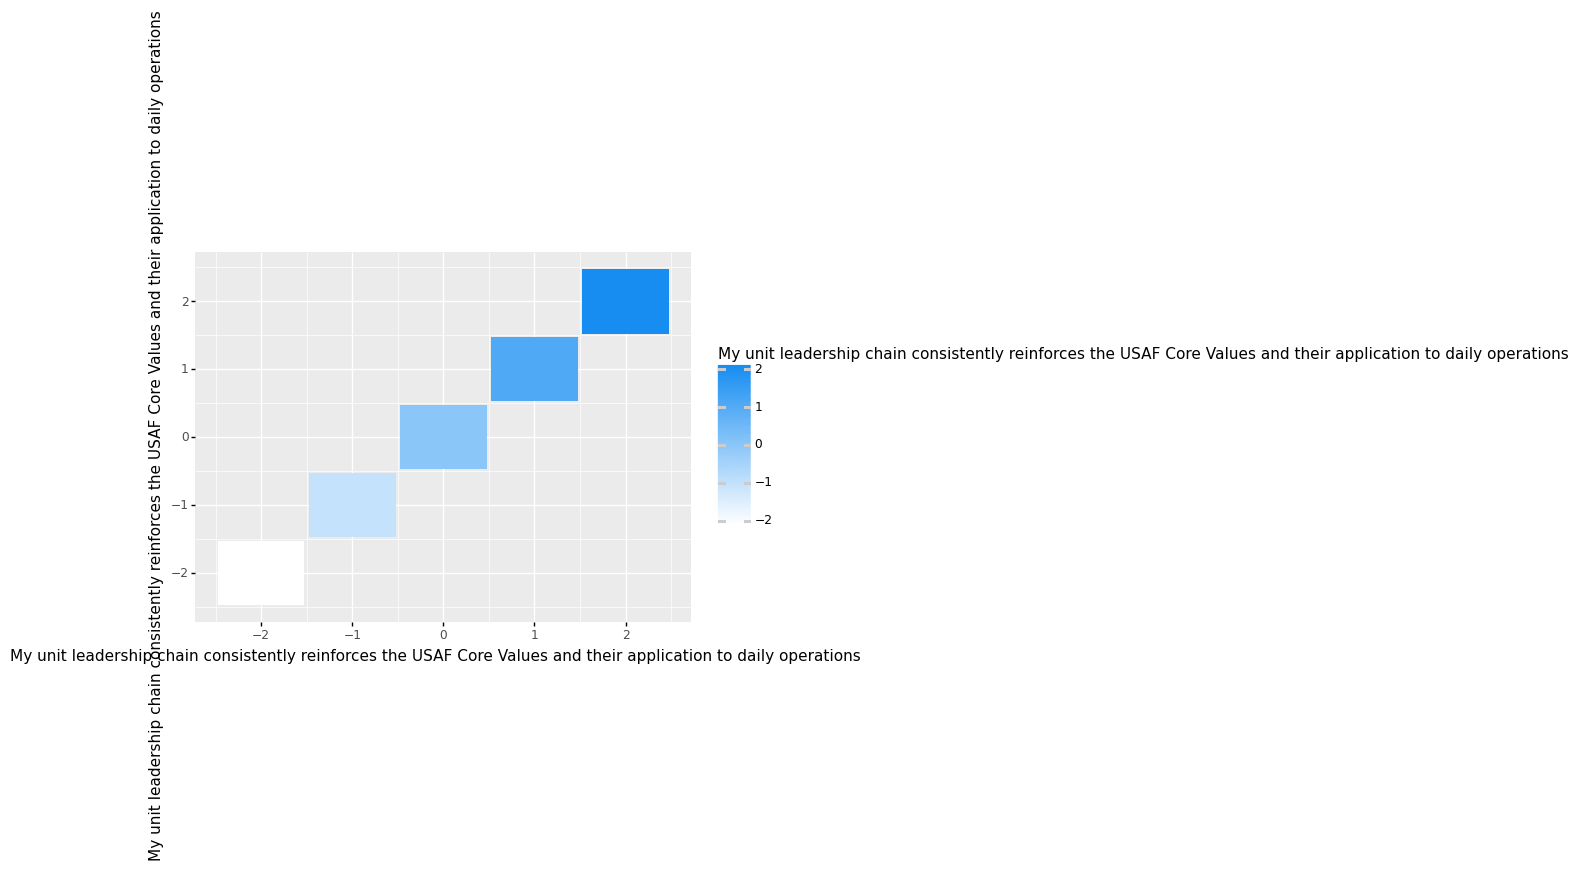

<ggplot: (133489670720)>

In [240]:
heatmap(df_temp5, q1, q2, fill=df_temp5[q1], label = "aaa")








### Principle Component Analysis

In [23]:
df_known = df_merged


# Variables for model building and exploration
Docs_known = df_known.drop(columns = ["Y"]+id_vars+ ["Rank"])
Cats_known = df_known.Y
X_columns = df_known.drop(columns = ["Y"]+id_vars+ ["Rank"]).columns
y_column = ["Y"]

# Split into train, test sets
df_known_train, df_known_test = train_test_split(df_known, test_size=0.2, random_state=25)

In [24]:
df_known_train[X_columns]

,A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command,Airmen in my unit consider the environmental impact of their actions,"During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review",I am allocated the correct amount of training hours each month to operate safely,I am encouraged to be innovative even if that means I might make a mistake,"I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time",I feel I am a valued member of my unit,I feel adequately prepared to deploy and execute my assigned AEF duties,I have been adequately trained for the job I am expected to do,"I have easy and timely access to the written guidance I need to do my job (e.g., AFIs, MAJCOM Supplements, TOs, Self-Assessment Communicators, etc)",I have enough time to accomplish my daily workload during my normal duty hours,"I have the equipment (tools, spare parts, information technology, safety gear, etc.) I need to do my job the right way",I have the opportunity to develop other professional skills,I have the opportunity to develop/improve my AFSC/Special Duty Identifier-related skills,"I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander)",I would be able to complete my assigned tasks if my work center lost communications capability,Individuals in my unit are comfortable approaching supervisors about personal problems,Members of my unit take good care of the equipment they use,My commander is concerned about my personal welfare,My deployment schedule is predictable enough for me to plan and participate in off-duty activities,My duty schedule is predictable enough for me to plan and participate in off-duty activities,My job is designed so I know when I have performed well,My leadership gets the right information about problems in my unit so he/she can fix them,"My position/job description (for both military and civilians) is current and accurately describes my daily functions, tasks and responsibilities",My supervisor corrects poor performance in my work group,My supervisor is concerned with my professional development,My unit accurately accounts for our equipment,My unit challenges inefficient ways of doing business,My unit closely monitors and tracks job qualifications,My unit has a sufficient number of experienced personnel to accomplish our primary mission,My unit has a sufficient number of personnel to accomplish our primary mission,My unit has an effective long-range scheduling process,My unit has processes in place to identify and share lessons learned,My unit has the sufficient funding to accomplish all of our missions,My unit is serious about preventing sexual assault and sexual harassment,My unit leadership chain applies disciplinary standards in a fair and consistent manner,My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations,My unit provides me sufficient time during working hours to participate in a physical fitness program,My unit spends end-of-year fallout money wisely,My unit takes suicide prevention seriously,My units communication processes prevent wasted effort and/or resources,My units communication system and information flow are effective up and down the chain of command,My units daily activities improve our ability to execute our most demanding mission,My units leaders reward individual performance fairly,My units strategic plan improves unit performance,My units strategic plan translates to what I do on a daily basis,My work center is adequately prepared to execute required operations during the most likely local contingencies,My work facilities enable effective mission accomplishment,Performing my primary AFSC duties is NOT significantly impacted by additional duties,Performing my primary AFSC duties i

In [25]:
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(df_known_train[X_columns])

In [26]:
pca.explained_variance_ratio_

array([0.33889555, 0.05878656, 0.02960134, 0.02701789, 0.0242248 ,
       0.02203921, 0.02066992, 0.01912456, 0.01806736, 0.01726343,
       0.01635123, 0.01502415, 0.014813  , 0.01382873, 0.01295936,
       0.01219423, 0.01200995, 0.01161409, 0.01140747, 0.01101191,
       0.01065145, 0.01031814, 0.0101181 , 0.00971797, 0.00959229,
       0.00931606, 0.00927133, 0.00888747, 0.00866199, 0.00860251,
       0.00849833, 0.00833424, 0.00829418, 0.00795601, 0.00790072,
       0.00779427, 0.00756692, 0.00741341, 0.00730247, 0.0072807 ,
       0.00716394, 0.00690026, 0.00672964, 0.00659521, 0.00638775,
       0.00634016, 0.0062202 , 0.00618889, 0.00600236, 0.00599614,
       0.00584501, 0.00574083, 0.00563681, 0.00541148, 0.00526198,
       0.00506292, 0.0049985 , 0.00492927, 0.00472034, 0.00387579,
       0.00189671, 0.00171248])

In [27]:
# Columns are the questions
# X index are the questions
pca_df = pd.DataFrame(pca.components_)
pca_df.columns = X_columns
pca_df.transpose().describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,-0.123572,0.009443,0.006856,0.002060,-0.004533,-0.014916,0.010290,0.001221,0.004504,0.007240,0.005371,-0.008047,0.001832,0.006756,-0.000025,-0.003704,-0.000269,-0.001162,-0.004143,0.001963,0.002281,0.002147,-0.001586,0.000068,0.006963,-0.000108,0.002265,-0.000201,0.002584,0.002050,-0.001980,-0.000720,0.001086,0.000818,-0.001352,0.001852,-0.001631,0.001545,-0.000058,-0.001204,0.001716,0.000127,-0.000635,0.001989,-0.000064,0.002165,0.002091,0.000259,0.000025,-0.000042,0.000269,0.000640,0.000552,-0.000185,0.000746,-0.000171,-0.000811,0.000872,-0.001420,-0.000055,0.000067,-0.000653
std,0.029548,0.127682,0.127850,0.128020,0.127955,0.127151,0.127616,0.128031,0.127956,0.127829,0.127922,0.127780,0.128024,0.127856,0.128037,0.127982,0.128037,0.128032,0.127969,0.128022,0.128016,0.128019,0.128027,0.128037,0.127844,0.128037,0.128017,0.128037,0.128010,0.128020,0.128021,0.128035,0.128032,0.128034,0.128030,0.128023,0.128026,0.128027,0.128037,0.128031,0.128025,0.128037,0.128035,0.128021,0.128037,0.128018,0.128020,0.128037,0.128037,0.128037,0.128037,0.128035,0.128036,0.128037,0.128035,0.128037,0.128034,0.128034,0.128029,0.128037,0.128037,0.128035
min,-0.182255,-0.153575,-0.290357,-0.435095,-0.250304,-0.305527,-0.543686,-0.283048,-0.359001,-0.265546,-0.554677,-0.420261,-0.228879,-0.463054,-0.305556,-0.375180,-0.295311,-0.242637,-0.508973,-0.264759,-0.278239,-0.304363,-0.387599,-0.337943,-0.419120,-0.386221,-0.425724,-0.377124,-0.495704,-0.337898,-0.350313,-0.347651,-0.341691,-0.342381,-0.346687,-0.262198,-0.379642,-0.338594,-0.302635,-0.284063,-0.300688,-0.468697,-0.425877,-0.344564,-0.460269,-0.383498,-0.599123,-0.348302,-0.285280,-0.457771,-0.323364,-0.487101,-0.263328,-0.516607,-0.251932,-0.440031,-0.373111,-0.634156,-0.499616,-0.569854,-0.708039,-0.732859
25%,-0.144543,-0.082422,-0.048907,-0.051479,-0.103395,-0.092290,-0.038082,-0.102409,-0.066035,-0.050276,-0.055112,-0.080808,-0.084646,-0.060391,-0.071216,-0.060150,-0.068596,-0.069402,-0.062072,-0.084854,-0.078868,-0.073994,-0.066283,-0.083489,-0.055105,-0.083199,-0.073709,-0.078985,-0.066769,-0.071252,-0.070491,-0.052818,-0.045522,-0.070643,-0.059638,-0.066200,-0.068727,-0.061552,-0.057848,-0.041353,-0.059331,-0.054997,-0.081555,-0.060727,-0.037511,-0.053814,-0.043249,-0.049803,-0.069635,-0.028586,-0.053232,-0.038514,-0.057909,-0.037745,-0.049310,-0.058127,-0.052608,-0.036359,-0.037496,-0.018863,-0.010718,-0.005407
50%,-0.123172,-0.028041,0.008670,0.000340,-0.019398,-0.012953,0.011923,-0.009960,0.029086,0.020332,-0.004046,-0.016070,0.015921,-0.004587,0.000573,0.003397,-0.005374,-0.017801,-0.017591,0.012169,0.010418,-0.002046,0.003734,-0.013848,0.006019,0.003101,0.006810,-0.007711,0.005598,0.011765,-0.005488,0.021014,-0.009491,0.000238,0.000253,-0.014388,0.008777,0.007650,-0.001282,0.010391,0.003152,0.005885,0.018295,-0.000334,0.002527,0.017777,0.014627,-0.001659,0.005074,0.000714,-0.005940,0.001528,-0.009531,-0.001189,-0.015063,-0.009498,-0.005019,0.001011,-0.004978,0.001866,0.001365,-0.001458
75%,-0.101114,0.094055,0.069246,0.056336,0.051507,0.067081,0.079127,0.088716,0.086619,0.071289,0.068148,0.071761,0.075480,0.078293,0.068966,0.028481,0.054639,0.038151,0.067532,0.066140,0.088357,0.104968,0.04

In [28]:
df_known_train[X_columns].corr()

,A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command,Airmen in my unit consider the environmental impact of their actions,"During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review",I am allocated the correct amount of training hours each month to operate safely,I am encouraged to be innovative even if that means I might make a mistake,"I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time",I feel I am a valued member of my unit,I feel adequately prepared to deploy and execute my assigned AEF duties,I have been adequately trained for the job I am expected to do,"I have easy and timely access to the written guidance I need to do my job (e.g., AFIs, MAJCOM Supplements, TOs, Self-Assessment Communicators, etc)",I have enough time to accomplish my daily workload during my normal duty hours,"I have the equipment (tools, spare parts, information technology, safety gear, etc.) I need to do my job the right way",I have the opportunity to develop other professional skills,I have the opportunity to develop/improve my AFSC/Special Duty Identifier-related skills,"I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander)",I would be able to complete my assigned tasks if my work center lost communications capability,Individuals in my unit are comfortable approaching supervisors about personal problems,Members of my unit take good care of the equipment they use,My commander is concerned about my personal welfare,My deployment schedule is predictable enough for me to plan and participate in off-duty activities,My duty schedule is predictable enough for me to plan and participate in off-duty activities,My job is designed so I know when I have performed well,My leadership gets the right information about problems in my unit so he/she can fix them,"My position/job description (for both military and civilians) is current and accurately describes my daily functions, tasks and responsibilities",My supervisor corrects poor performance in my work group,My supervisor is concerned with my professional development,My unit accurately accounts for our equipment,My unit challenges inefficient ways of doing business,My unit closely monitors and tracks job qualifications,My unit has a sufficient number of experienced personnel to accomplish our primary mission,My unit has a sufficient number of personnel to accomplish our primary mission,My unit has an effective long-range scheduling process,My unit has processes in place to identify and share lessons learned,My unit has the sufficient funding to accomplish all of our missions,My unit is serious about preventing sexual assault and sexual harassment,My unit leadership chain applies disciplinary standards in a fair and consistent manner,My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations,My unit provides me sufficient time during working hours to participate in a physical fitness program,My unit spends end-of-year fallout money wisely,My unit takes suicide prevention seriously,My units communication processes prevent wasted effort and/or resources,My units communication system and information flow are effective up and down the chain of command,My units daily activities improve our ability to execute our most demanding mission,My units leaders reward individual performance fairly,My units strategic plan improves unit performance,My units strategic plan translates to what I do on a daily basis,My work center is adequately prepared to execute required operations during the most likely local contingencies,My work facilities enable effective mission accomplishment,Performing my primary AFSC duties is NOT significantly impacted by additional duties,Performing my primary AFSC duties i

In [29]:
import seaborn as sn
import matplotlib.pyplot as plt

In [30]:
pd.DataFrame(df_known_train[X_columns].corr().median().sort_values())

,0
I would be able to complete my assigned tasks if my work center lost communications capability,0.164321
I have enough time to accomplish my daily workload during my normal duty hours,0.192583
Performing my primary AFSC duties is NOT significantly impacted by ancillary training,0.193518
"I have easy and timely access to the written guidance I need to do my job (e.g., AFIs, MAJCOM Supplements, TOs, Self-Assessment Communicators, etc)",0.212138
Performing my primary AFSC duties is NOT significantly impacted by additional duties,0.224772
My unit has the sufficient funding to accomplish all of our missions,0.224985
My unit has a sufficient number of personnel to accomplish our primary mission,0.225365
My deployment schedule is predictable enough for me to plan and participate in off-duty activities,0.232045
I feel adequately prepared to deploy and execute my assigned AEF duties,0.243089
Members of my unit take good care of the equipment they use,0.244739


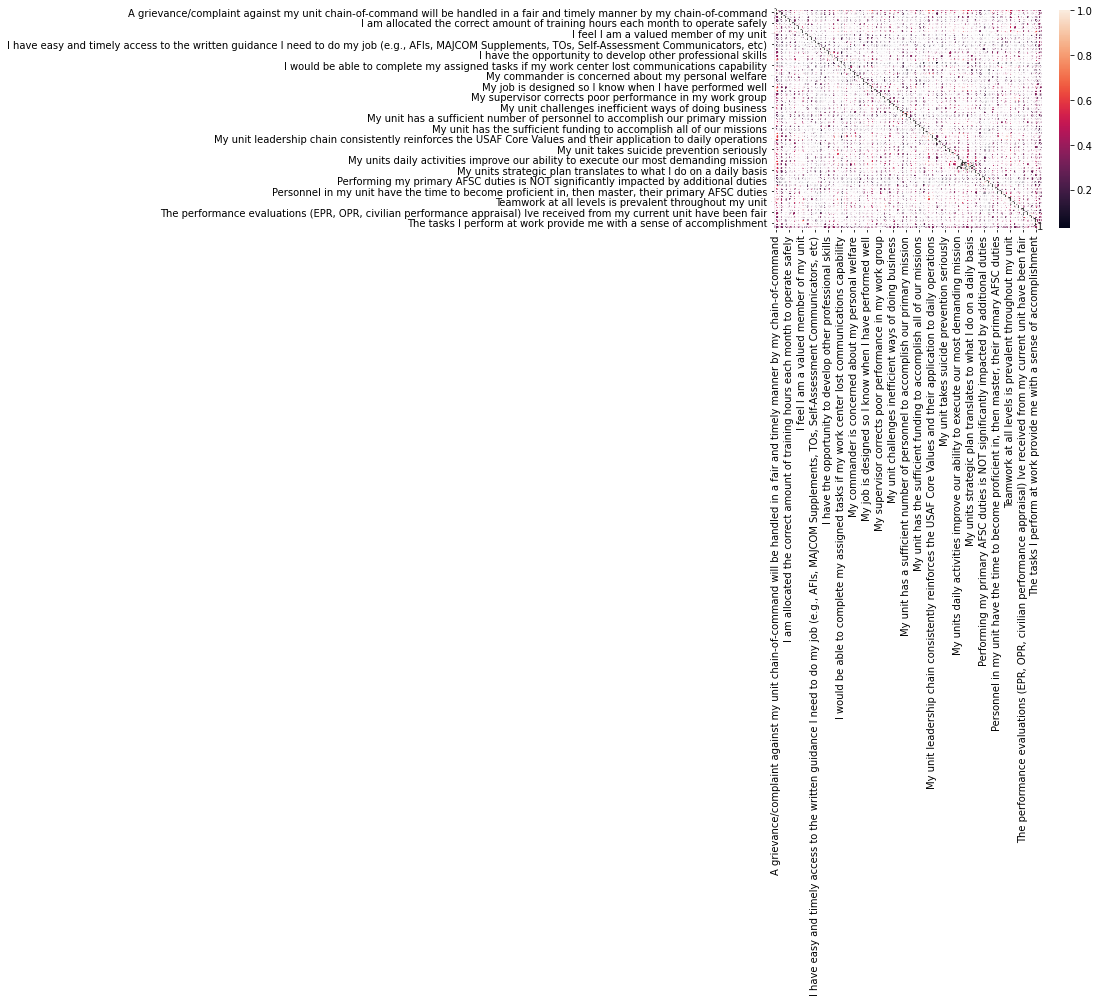

In [31]:
sn.heatmap(df_known_train[X_columns].corr(), annot=True)
plt.show()

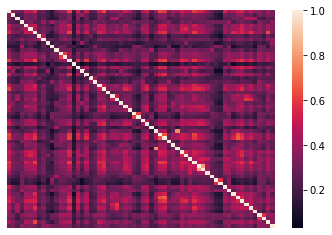

In [32]:
sn.heatmap(df_known_train[X_columns].corr(), annot=False, xticklabels=False, yticklabels=False)
plt.show()

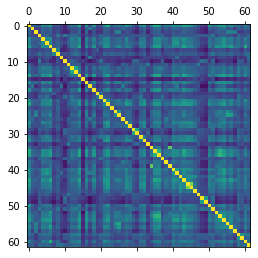

In [33]:
plt.matshow(df_known_train[X_columns].corr())
plt.show()

In [34]:
df_known_train[X_columns].corr().min().min()

0.02940321440837318

In [35]:
df_known_train[X_columns].corr().median().median()

0.3380567729694438

### Factor Analysis

In [36]:
# Obtain the p-value (0.0)
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_merged[X_columns])
chi_square_value, p_value

(241091.3679399404, 0.0)

In [37]:
# Obtain the Kaiser-Meyer-Olkin (KMO) Test value
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df_merged[X_columns])

# Factor analysis requires a value above 0.6. Higher is better. 
kmo_model

C:\Users\girscjg1\Anaconda3\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.9782584644052078

In [38]:
df_merged[X_columns]

,A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command,Airmen in my unit consider the environmental impact of their actions,"During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review",I am allocated the correct amount of training hours each month to operate safely,I am encouraged to be innovative even if that means I might make a mistake,"I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time",I feel I am a valued member of my unit,I feel adequately prepared to deploy and execute my assigned AEF duties,I have been adequately trained for the job I am expected to do,"I have easy and timely access to the written guidance I need to do my job (e.g., AFIs, MAJCOM Supplements, TOs, Self-Assessment Communicators, etc)",I have enough time to accomplish my daily workload during my normal duty hours,"I have the equipment (tools, spare parts, information technology, safety gear, etc.) I need to do my job the right way",I have the opportunity to develop other professional skills,I have the opportunity to develop/improve my AFSC/Special Duty Identifier-related skills,"I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander)",I would be able to complete my assigned tasks if my work center lost communications capability,Individuals in my unit are comfortable approaching supervisors about personal problems,Members of my unit take good care of the equipment they use,My commander is concerned about my personal welfare,My deployment schedule is predictable enough for me to plan and participate in off-duty activities,My duty schedule is predictable enough for me to plan and participate in off-duty activities,My job is designed so I know when I have performed well,My leadership gets the right information about problems in my unit so he/she can fix them,"My position/job description (for both military and civilians) is current and accurately describes my daily functions, tasks and responsibilities",My supervisor corrects poor performance in my work group,My supervisor is concerned with my professional development,My unit accurately accounts for our equipment,My unit challenges inefficient ways of doing business,My unit closely monitors and tracks job qualifications,My unit has a sufficient number of experienced personnel to accomplish our primary mission,My unit has a sufficient number of personnel to accomplish our primary mission,My unit has an effective long-range scheduling process,My unit has processes in place to identify and share lessons learned,My unit has the sufficient funding to accomplish all of our missions,My unit is serious about preventing sexual assault and sexual harassment,My unit leadership chain applies disciplinary standards in a fair and consistent manner,My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations,My unit provides me sufficient time during working hours to participate in a physical fitness program,My unit spends end-of-year fallout money wisely,My unit takes suicide prevention seriously,My units communication processes prevent wasted effort and/or resources,My units communication system and information flow are effective up and down the chain of command,My units daily activities improve our ability to execute our most demanding mission,My units leaders reward individual performance fairly,My units strategic plan improves unit performance,My units strategic plan translates to what I do on a daily basis,My work center is adequately prepared to execute required operations during the most likely local contingencies,My work facilities enable effective mission accomplishment,Performing my primary AFSC duties is NOT significantly impacted by additional duties,Performing my primary AFSC duties i

In [39]:
# Next, determine the correct number of factors using the Kaiser criterion and the scree plot

In [40]:
#Using Numpy on the Previously Defined X-Y
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA()

X_r = pca.fit_transform(df_merged[X_columns])
print('\nEigenvalues \n%s' %pd.DataFrame(pca.explained_variance_))


Eigenvalues 
            0
0   23.319493
1    4.025561
2    2.021408
3    1.846937
4    1.649486
5    1.490936
6    1.395636
7    1.316547
8    1.246737
9    1.168176
10   1.116187
11   1.019164
12   0.997844
13   0.936071
14   0.906380
15   0.825439
16   0.821253
17   0.793649
18   0.780106
19   0.755602
20   0.718031
21   0.705230
22   0.700855
23   0.669664
24   0.645479
25   0.636117
26   0.625655
27   0.608351
28   0.595912
29   0.594802
30   0.579563
31   0.572164
32   0.561472
33   0.545397
34   0.539649
35   0.536602
36   0.517409
37   0.512603
38   0.501270
39   0.496751
40   0.492542
41   0.474672
42   0.457546
43   0.451888
44   0.438923
45   0.434063
46   0.426743
47   0.424223
48   0.418199
49   0.410128
50   0.407238
51   0.395631
52   0.384138
53   0.377999
54   0.364095
55   0.350968
56   0.341095
57   0.339608
58   0.326303
59   0.263234
60   0.127977
61   0.121129


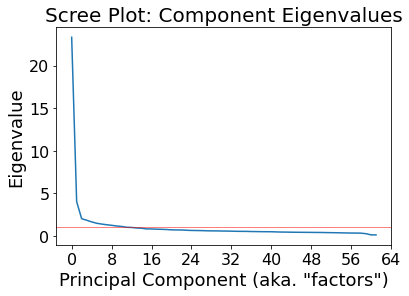

In [41]:
def scree_plot():
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(pca.explained_variance_)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Principal Component (aka. "factors")', fontsize = 18)
    plt.ylabel('Eigenvalue', fontsize = 18)
    plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Scree Plot: Component Eigenvalues', fontsize = 20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    show()

scree_plot()

In [63]:
number_of_factors = 25 # Equal to # of components with Eigenvalue above 1.0. Update: Tuned from 13 down to 9. 
fa = FactorAnalyzer(n_factors = number_of_factors, rotation = 'varimax') # try rotation = None
fa.fit(df_merged[X_columns])
loadings = fa.loadings_
factor_temp_df = pd.DataFrame(fa.get_factor_variance(), index = ["Sum of squared loadings (variance)",
                                                      "Proportional variance","Cumulative variance"])

round(factor_temp_df,2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Sum of squared loadings (variance),10.91,2.50,1.80,1.77,1.72,1.69,1.57,1.52,1.24,1.23,1.18,1.09,1.00,0.99,0.98,0.66,0.63,0.54,0.52,0.40,0.38,0.26,0.26,0.22,0.18
Proportional variance,0.18,0.04,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00
Cumulative variance,0.18,0.22,0.25,0.27,0.30,0.33,0.35,0.38,0.40,0.42,0.44,0.46,0.47,0.49,0.50,0.51,0.52,0.53,0.54,0.55,0.55,0.56,0.56,0.57,0.57


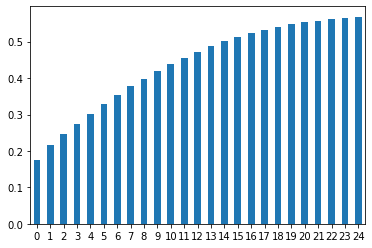

In [64]:
ax =factor_temp_df.loc["Cumulative variance",:].plot.bar(rot=0)

In [43]:
# Transform loadings array to dataframes and designate each index with the correct question

loadings_df = pd.DataFrame(loadings)
loadings_df = loadings_df.set_index(X_columns)


# Rename each factor accoring to their previously  identified group similarities. 
factor_name_dict = {0:"Leadership", 1:"Strategic Plan", 2:"Impact of Additional Duties",
                    3:"Equipment", 4:"Duty Schedule", 5:"Supervisor", 6:"Adequate Training",
                    7:"Sufficient Personnel", 8:"Sexual Harrassment / Suicide"}
loadings_df.rename(factor_name_dict, axis='columns', inplace=True)

# Add the "max_abs_load" criteria and use it to filter to only factors that have questions that meet a 0.5 threshold with any factor. 
loadings_df_2 = loadings_df.copy()
loadings_df_2["max_abs_load"] = loadings_df.T.abs().max()
loadings_df_filtered_rows = loadings_df_2[loadings_df_2["max_abs_load"]>0.5]
#loadings_df_filtered_rows = loadings_df

In [44]:
loadings_df

,Leadership,Strategic Plan,Impact of Additional Duties,Equipment,Duty Schedule,Supervisor,Adequate Training,Sufficient Personnel,Sexual Harrassment / Suicide
A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command,0.625469,0.356631,0.119885,0.104159,0.110926,0.098622,0.080584,0.109911,0.162220
Airmen in my unit consider the environmental impact of their actions,0.307680,0.169301,0.062672,0.335951,0.123373,0.083269,0.140635,0.079740,0.073177
"During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review",0.279746,0.122898,0.071377,0.065552,0.082693,0.508552,0.149903,0.031514,0.062785
I am allocated the correct amount of training hours each month to operate safely,0.118777,0.121666,0.371669,0.259611,0.227455,0.129901,0.214480,0.169683,0.074311
I am encouraged to be innovative even if that means I might make a mistake,0.543914,0.163897,0.096541,0.161891,0.288888,0.150530,0.105919,0.080381,0.002497
"I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time",0.466219,0.192984,0.154693,0.234213,0.288530,0.147220,0.122679,0.151891,0.024834
I feel I am a valued member of my unit,0.653185,0.164366,0.050687,0.093109,0.223593,0.199894,0.248758,0.042586,0.101165
I feel adequately prepared to deploy and execute my assigned AEF duties,0.174537,0.128005,0.031018,0.098726,0.131125,0.086024,0.477536,0.061096,0.105460
I have been adequately trained for the job I am expected to do,0.178746,0.140711,0.210178,0.167490,0.043141,0.197867,0.561759,0.126607,0.072223
"I have easy and timely access to the written guidance I need to do my job (e.g., AFIs, MAJCOM Supplements, TOs, Self-Assessment Communicators, etc)",0.132233,0.033998,0.129116,0.504517,0.105787,0.083664,0.118927,0.015705,0.070150


In [71]:
# Eliminate any factors that don't have at least 1 question that meets the 0.5 threshold (usually eliminates none)
keep_loadings_columns = loadings_df_filtered_rows.max()[loadings_df_filtered_rows.max()>0.5].index

# Build a dictionary that identifies the essential questions for each factor
factor_essential_loadings_dict = {}
loadings_df_filtered_rows_columns = loadings_df_filtered_rows[keep_loadings_columns]
for col in loadings_df_filtered_rows_columns.columns:
    if col != "max_abs_load":
        factor_essential_loadings_dict[col] = loadings_df_filtered_rows_columns[loadings_df_filtered_rows_columns[col]>0.5][col]
        print("column: ", str(col)+":")
        print(loadings_df_filtered_rows_columns[loadings_df_filtered_rows_columns[col]>0.5].sort_values(by=col, ascending = False)[col])
        print("")


column:  Leadership:
My unit leadership chain applies disciplinary standards in a fair and consistent manner                                      0.707684
My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations              0.700365
I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander)                                  0.673083
My units leaders reward individual performance fairly                                                                        0.659162
I feel I am a valued member of my unit                                                                                       0.653185
A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command    0.625469
Teamwork at all levels is prevalent throughout my unit                                                                       0.617372
Standards in my unit are enforced        

In [72]:
# Use the above results to alter "factor_name_dict" to name of each factor like "Leadership"
# This is the end of the Exploratory Factor Analysis
# # https://www.datacamp.com/community/tutorials/introduction-factor-analysis

### Clustering Analysis

In [73]:
df_merged2 = df_merged.copy()
df_merged.to_csv("clustering_data/pre_clustering_csv.csv")

In [74]:
# Use the loadings of the identified questions that meet the threshold to build a weighted column for each factor. 
# Rather than use all questions for each factor, only questions that meet the 0.5 threshold will be used. 

for factor in factor_essential_loadings_dict.keys():
    df_merged2[factor] = (df_merged2[factor_essential_loadings_dict[factor].index]*factor_essential_loadings_dict[factor]).sum(axis=1)


In [76]:
df_merged2

,unit_orig,unit_type,My rank is: Response,Rank,Year,A grievance/complaint against my unit chain-of-command will be handled in a fair and timely manner by my chain-of-command,Airmen in my unit consider the environmental impact of their actions,"During my performance feedback session, my supervisor provided me with feedback that enabled me to improve my performance prior to my annual performance review",I am allocated the correct amount of training hours each month to operate safely,I am encouraged to be innovative even if that means I might make a mistake,"I am informed of critical information (e.g. work schedules, policies, uniform of the day, etc.) in a reasonable amount of time",I feel I am a valued member of my unit,I feel adequately prepared to deploy and execute my assigned AEF duties,I have been adequately trained for the job I am expected to do,"I have easy and timely access to the written guidance I need to do my job (e.g., AFIs, MAJCOM Supplements, TOs, Self-Assessment Communicators, etc)",I have enough time to accomplish my daily workload during my normal duty hours,"I have the equipment (tools, spare parts, information technology, safety gear, etc.) I need to do my job the right way",I have the opportunity to develop other professional skills,I have the opportunity to develop/improve my AFSC/Special Duty Identifier-related skills,"I trust my leadership chain, from my supervisor to my Wing Commander (or FOA/DRU Commander)",I would be able to complete my assigned tasks if my work center lost communications capability,Individuals in my unit are comfortable approaching supervisors about personal problems,Members of my unit take good care of the equipment they use,My commander is concerned about my personal welfare,My deployment schedule is predictable enough for me to plan and participate in off-duty activities,My duty schedule is predictable enough for me to plan and participate in off-duty activities,My job is designed so I know when I have performed well,My leadership gets the right information about problems in my unit so he/she can fix them,"My position/job description (for both military and civilians) is current and accurately describes my daily functions, tasks and responsibilities",My supervisor corrects poor performance in my work group,My supervisor is concerned with my professional development,My unit accurately accounts for our equipment,My unit challenges inefficient ways of doing business,My unit closely monitors and tracks job qualifications,My unit has a sufficient number of experienced personnel to accomplish our primary mission,My unit has a sufficient number of personnel to accomplish our primary mission,My unit has an effective long-range scheduling process,My unit has processes in place to identify and share lessons learned,My unit has the sufficient funding to accomplish all of our missions,My unit is serious about preventing sexual assault and sexual harassment,My unit leadership chain applies disciplinary standards in a fair and consistent manner,My unit leadership chain consistently reinforces the USAF Core Values and their application to daily operations,My unit provides me sufficient time during working hours to participate in a physical fitness program,My unit spends end-of-year fallout money wisely,My unit takes suicide prevention seriously,My units communication processes prevent wasted effort and/or resources,My units communication system and information flow are effective up and down the chain of command,My units daily activities improve our ability to execute our most demanding mission,My units leaders reward individual performance fairly,My units strategic plan improves unit performance,My units strategic plan translates to what I do on a daily basis,My work center is adequately prepared to execute required operations during the most likely local contingencies,My work facilities enable effective mission accomplishment,Y,Performing my primary AFSC duties is NOT significantly impacted by 

In [75]:

# https://machinelearningmastery.com/clustering-algorithms-with-python/

from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
from sklearn.cluster import KMeans

num_clusters = 5
writer2 = pd.ExcelWriter(r"clustering_data/"+str(num_clusters)+"_clusters_factors.xlsx")

for j in range(10):

    cluster_X_columns = ['My unit leadership chain applies disciplinary standards in a fair and consistent manner',
                         'My units strategic plan translates to what I do on a daily basis',
                         'Performing my primary AFSC duties is NOT significantly impacted by additional duties',
                         'Members of my unit take good care of the equipment they use',
                         'My duty schedule is predictable enough for me to plan and participate in off-duty activities',
                         'My supervisor is concerned with my professional development',
                         'I have been adequately trained for the job I am expected to do',
                         'My unit has a sufficient number of personnel to accomplish our primary mission',
                         'My unit is serious about preventing sexual assault and sexual harassment'] # unused atm
    cluster_X_columns = list(factor_essential_loadings_dict.keys())

    # define the model
    #model = DBSCAN(eps=0.20, min_samples=3)
    model = GaussianMixture(n_components=num_clusters, random_state=1)
    #model = KMeans(init="random", n_clusters=9, n_init=10,  max_iter=300,  random_state=42)

    # Scaled Featuers
    scaler = StandardScaler()
    Scaled_Features = scaler.fit_transform(df_merged2[cluster_X_columns ])


    # fit the model
    yhat = model.fit_predict(Scaled_Features)

    # assign a cluster to each example
    df_merged_cluster = pd.DataFrame(Scaled_Features, columns = cluster_X_columns).copy()
    ###yhat = model.predict(Scaled_Features)


    df_merged_cluster['clusters'] = yhat
    df_merged2['clusters'] = yhat 

    # Add back and process observational variables
    numerical_observational_columns = ['Y'] # ["Rank"] 
    Scaled_Features = scaler.fit_transform(df_merged2[numerical_observational_columns ])
    df_observational = pd.DataFrame(Scaled_Features, columns = numerical_observational_columns).copy()
    df_merged_cluster[numerical_observational_columns] = df_observational[numerical_observational_columns].values #= ["My rank is: Response","unit_orig", "unit_type", "Year"]

    # Create aggregate cluster dataframe
    aggregate_df = pd.DataFrame(columns = cluster_X_columns + numerical_observational_columns + ["size"]   )
    for rank in sorted(set(df_merged["My rank is: Response"].unique())):
            aggregate_df[rank] = ""
            #aggregate_df[rank+"_perc"] = 0.0
    for un_t in sorted(set(df_merged["unit_type"].unique())):
            aggregate_df[un_t] = ""
    for loc in sorted(set(df_merged2["location"].value_counts().head().index)):
            aggregate_df[loc] = ""
    for wing in sorted(set(df_merged2["wing"].value_counts().head().index)):
            aggregate_df[wing] = ""
            #aggregate_df[un_t+"_perc"] = 0.0
    for cat in sorted(set(df_merged2["nma_category"].value_counts().head().index)):
            aggregate_df[cat] = ""
            #df_merged2.nma_category.value_counts().head().index
            
    for cluster in range(num_clusters):
        
        
        # Implement cluster_size columns
        sub_cluster_df = df_merged_cluster.loc[df_merged_cluster.clusters == cluster, cluster_X_columns+numerical_observational_columns ]
        sub_cluster_len = len(sub_cluster_df)
        print("cluster:", cluster, "cluster_size: ", sub_cluster_len)
        # Initialize subcluster row
        sub_cluster_agg_df = pd.DataFrame(round(sub_cluster_df.mean(),2)).T
        sub_cluster_agg_df["size"] = sub_cluster_len
        
        # Implement rank columns
        for rank in sorted(set(df_merged["My rank is: Response"].unique())):
            sub_cluster_agg_df[rank] = len(df_merged2.loc[(df_merged2["My rank is: Response"] == rank)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[rank+"_perc"] = round(len(df_merged2.loc[(df_merged2["My rank is: Response"] == rank)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        for un_t in sorted(set(df_merged["unit_type"].unique())):
            sub_cluster_agg_df[un_t] = len(df_merged2.loc[(df_merged2["unit_type"] == un_t)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[un_t+"_perc"] = round(len(df_merged2.loc[(df_merged2["unit_type"] == un_t)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        for loc in sorted(set(df_merged2["location"].value_counts().head().index)):
            sub_cluster_agg_df[loc] = len(df_merged2.loc[(df_merged2["location"] == loc)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[loc+"_perc"] = round(len(df_merged2.loc[(df_merged2["location"] == loc)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        for wing in sorted(set(df_merged2["wing"].value_counts().head().index)):
            sub_cluster_agg_df[wing] = len(df_merged2.loc[(df_merged2["wing"] == wing)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[wing+"_perc"] = round(len(df_merged2.loc[(df_merged2["wing"] == wing)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)
        for cat in sorted(set(df_merged2["nma_category"].value_counts().head().index)):
            sub_cluster_agg_df[cat] = len(df_merged2.loc[(df_merged2["nma_category"] == cat)&(df_merged2.clusters == cluster), : ])
            sub_cluster_agg_df[cat+"_perc"] = round(len(df_merged2.loc[(df_merged2["nma_category"] == cat)&(df_merged2.clusters == cluster), : ])/len(df_merged2.loc[(df_merged2.clusters == cluster), : ]),2)

        
        
        
        sub_cluster_agg_df.index = [cluster]
        
        # Concatenate cluster row
        aggregate_df = pd.concat([aggregate_df, sub_cluster_agg_df])

    aggregate_df_analyzed = aggregate_df.copy()
    aggregate_df_analyzed["factor_description"] = ""

    for index, row in aggregate_df_analyzed.iterrows():
        #print("index", index)
        try:
            for factor in cluster_X_columns:
                smallest_var = aggregate_df_analyzed[factor].sort_values().unique()[0]
                second_smallest_var = aggregate_df_analyzed[factor].sort_values().unique()[1]
                largest_var = aggregate_df_analyzed[factor].sort_values().unique()[-1]
                second_largest_var = aggregate_df_analyzed[factor].sort_values().unique()[-2]

                if aggregate_df_analyzed.loc[index, factor] == smallest_var:
                    aggregate_df_analyzed.loc[index, "factor_description"] =  aggregate_df_analyzed.loc[index, "factor_description"] + "Worst \"" + factor + "\"" + ".   "   

                #elif aggregate_df_analyzed.loc[index, factor] == second_smallest_var:
                 #   aggregate_df_analyzed.loc[index, "factor_description"] =  aggregate_df_analyzed.loc[index, "factor_description"] + "Second worst \"" + factor + "\"" + ".   "

                elif aggregate_df_analyzed.loc[index, factor] == largest_var:
                    aggregate_df_analyzed.loc[index, "factor_description"] =  aggregate_df_analyzed.loc[index, "factor_description"] + "Best \"" + factor + "\"" +  ".   "

                #elif aggregate_df_analyzed.loc[index, factor] == second_largest_var:
                   # aggregate_df_analyzed.loc[index, "factor_description"] =  aggregate_df_analyzed.loc[index, "factor_description"] + "Second best \"" + factor + "\"" + ".   "

                else:
                    pass
        except:
            print("error. skip.")
            pass
    aggregate_df_analyzed.to_excel(writer2, sheet_name = 'f_'+str(j), index = False)
 
    
writer2.save()
writer2.close()
aggregate_df.sort_values(by=['Y'], ascending=False)
#df_merged_cluster.loc[:, id_vars] = df_merged2[id_vars]

cluster: 0 cluster_size:  455
cluster: 1 cluster_size:  729
cluster: 2 cluster_size:  3337
cluster: 3 cluster_size:  388
cluster: 4 cluster_size:  2958
cluster: 0 cluster_size:  455
cluster: 1 cluster_size:  729
cluster: 2 cluster_size:  3337
cluster: 3 cluster_size:  388
cluster: 4 cluster_size:  2958
cluster: 0 cluster_size:  455
cluster: 1 cluster_size:  729
cluster: 2 cluster_size:  3337
cluster: 3 cluster_size:  388
cluster: 4 cluster_size:  2958
cluster: 0 cluster_size:  455
cluster: 1 cluster_size:  729
cluster: 2 cluster_size:  3337
cluster: 3 cluster_size:  388
cluster: 4 cluster_size:  2958
cluster: 0 cluster_size:  455
cluster: 1 cluster_size:  729
cluster: 2 cluster_size:  3337
cluster: 3 cluster_size:  388
cluster: 4 cluster_size:  2958


KeyboardInterrupt: 

In [47]:
df_merged2.nma_category.value_counts().head().index

Index(['Tanker', 'Bomber', 'DCA', 'Space', 'Missile'], dtype='object')

In [48]:
df_merged2.to_csv("clustering_data/post_clustering_csv.csv")

In [48]:
# LEFT OFF HERE: 
# Potential Descriptor variables to add: 
# On a scale of 1 to 10 (1- low, 10-high), rate how much time, energy and effort your unit has devoted to inspection prep at the expense of mission readiness
# On a scale of 1 (worst) to 10 (best), please rate your current quality of home life (QOHL) at your current assignment. QOHL is the degree to which you enjoy where you live and the opportunities available for housing, recreation, etc
# My current workweek is ... (Actual time spent at work not including commute time)

